In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import multiprocessing as mp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

ee.Initialize()


%load_ext autoreload
%autoreload 2

In [2]:
def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/GRACE/SNODAS_GRACE_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - monthly SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_inflow(stid, startdate, enddate):
    '''
    Fetch the daily reservoir inflow for a CDEC reservoir ID
    Input: stid (str) - 3 letter station id (ex: ISB)
    Output: Sres - (pd.DataFrame) - the full monthly flow (km^3 / mon)
    '''
    # Download Storage (SensorNums = 65) data by query str:
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    url = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01'''.format(stid)
    print(url)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    inflow = pd.to_numeric(df.VALUE, errors='coerce')
    indf = pd.DataFrame(zip(dt_idx,inflow* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return rs.col_to_dt(indf)


def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)


def make_plots(lagim, maxcorim, meanswe):
    
    # Plot lag images 
    plt.figure(figsize = (10, 15))

    # First image ###########
    plt.subplot(3,1,1)

    ax = plt.gca()
    im1 = ax.imshow(lagim)

    # create cax for cbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im1, cax=cax)
    ax.set_title("Time of peak Xcorr lag (days prior)")
    
    # Sec image ###########
    plt.subplot(3,1,2)

    ax = plt.gca()
    im1 = ax.imshow(maxcorim)

    # create cax for cbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im1, cax=cax)
    ax.set_title("Magnitude of peak Xcorr")
    
    # Third image ###########
    plt.subplot(3,1,3)
    ax3 = plt.gca()
    im3 = ax3.imshow(meanswe)

    # create cax for cbar
    divider3 = make_axes_locatable(ax3)
    cax2 = divider3.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im3, cax=cax2)
    ax3.set_title("mean SWE (m )")

    plt.tight_layout()
    plt.show()

    

In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")

# Set start / end date
startdate = '2003-09-30'
enddate = '2019-10-01'
dt_idx = pd.date_range(startdate,enddate, freq='D')

In [4]:
# Big loop through all catchments to get the data, do the xcorrelation, and write files 

0
************************************************************
PAR MOKELUMNE R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=PAR&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


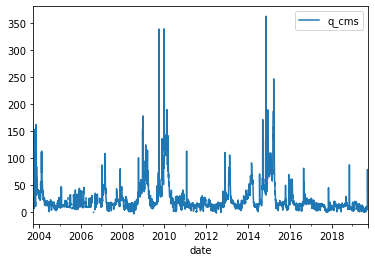

100%|██████████| 6210/6210 [08:14<00:00, 12.56it/s]


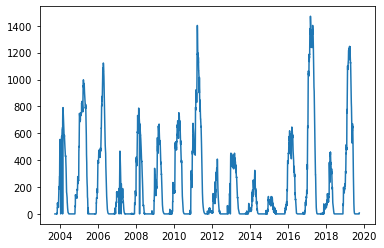

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/PAR_swe.tif
wrote ../rasters/PAR_lag.tif
wrote ../rasters/PAR_cormax.tif


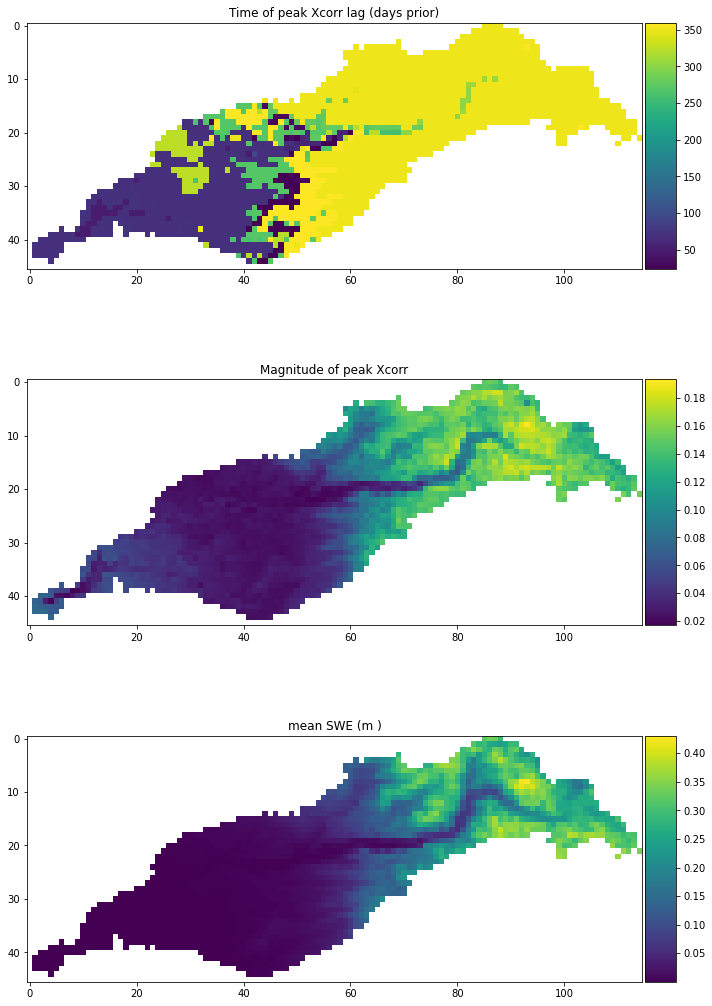

1
************************************************************
MIL SAN JOAQUIN R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=MIL&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


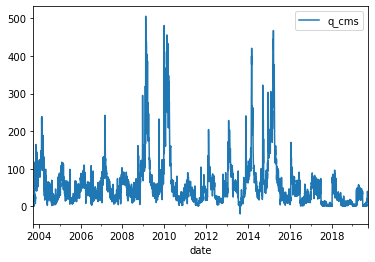

100%|██████████| 6210/6210 [09:59<00:00, 10.36it/s]


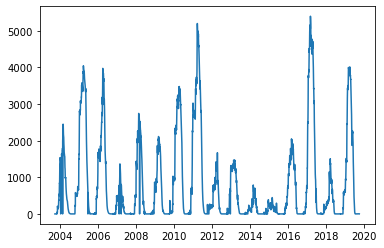

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/MIL_swe.tif
wrote ../rasters/MIL_lag.tif
wrote ../rasters/MIL_cormax.tif


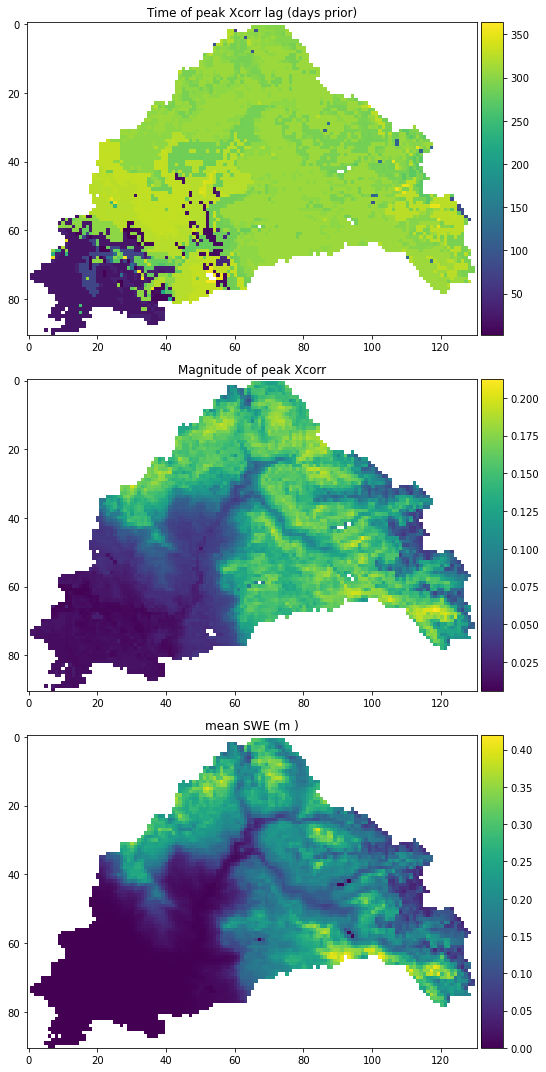

2
************************************************************
ISB KERN R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=ISB&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


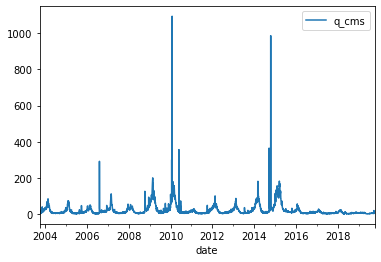

100%|██████████| 6210/6210 [20:38<00:00,  5.01it/s]


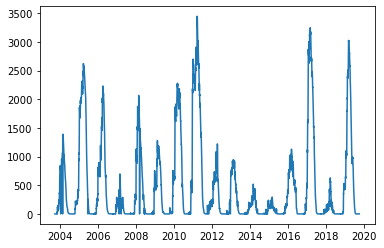

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/ISB_swe.tif
wrote ../rasters/ISB_lag.tif
wrote ../rasters/ISB_cormax.tif


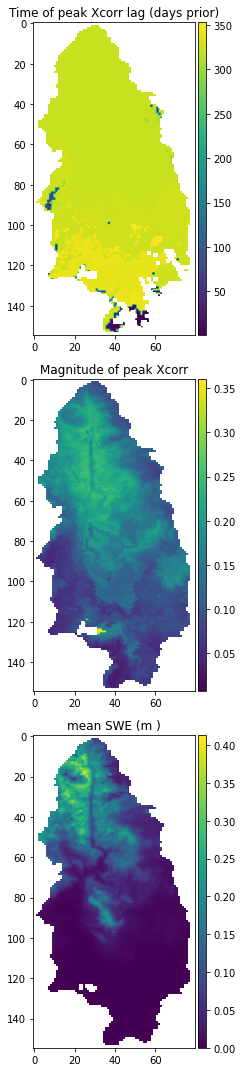

3
************************************************************
DNP TUOLUMNE R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=DNP&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


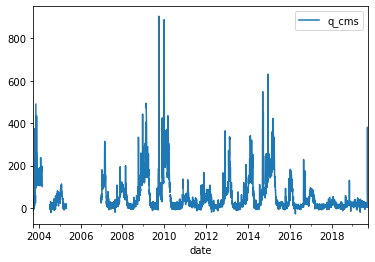

100%|██████████| 6210/6210 [20:10<00:00,  5.13it/s]  


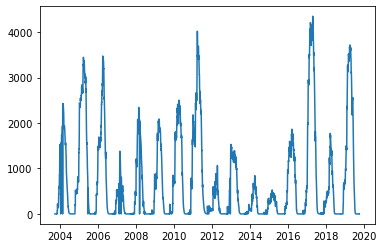

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/DNP_swe.tif
wrote ../rasters/DNP_lag.tif
wrote ../rasters/DNP_cormax.tif


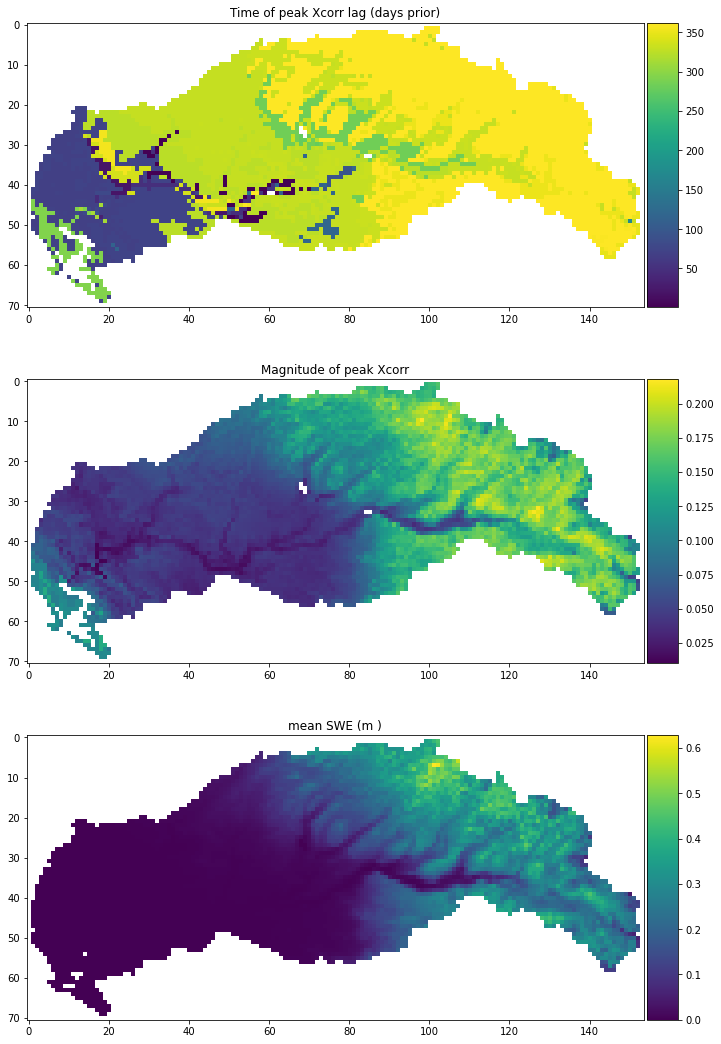

4
************************************************************
NML STANISLAUS R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=NML&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


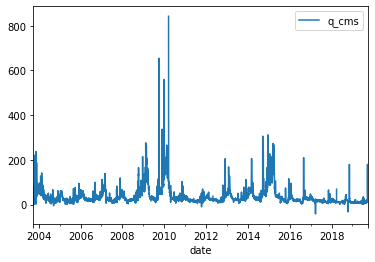

100%|██████████| 6210/6210 [13:50<00:00,  7.48it/s]  


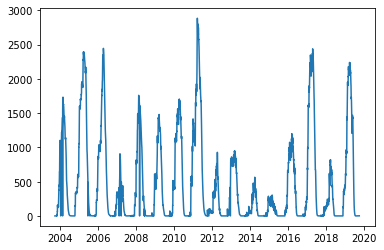

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/NML_swe.tif
wrote ../rasters/NML_lag.tif
wrote ../rasters/NML_cormax.tif


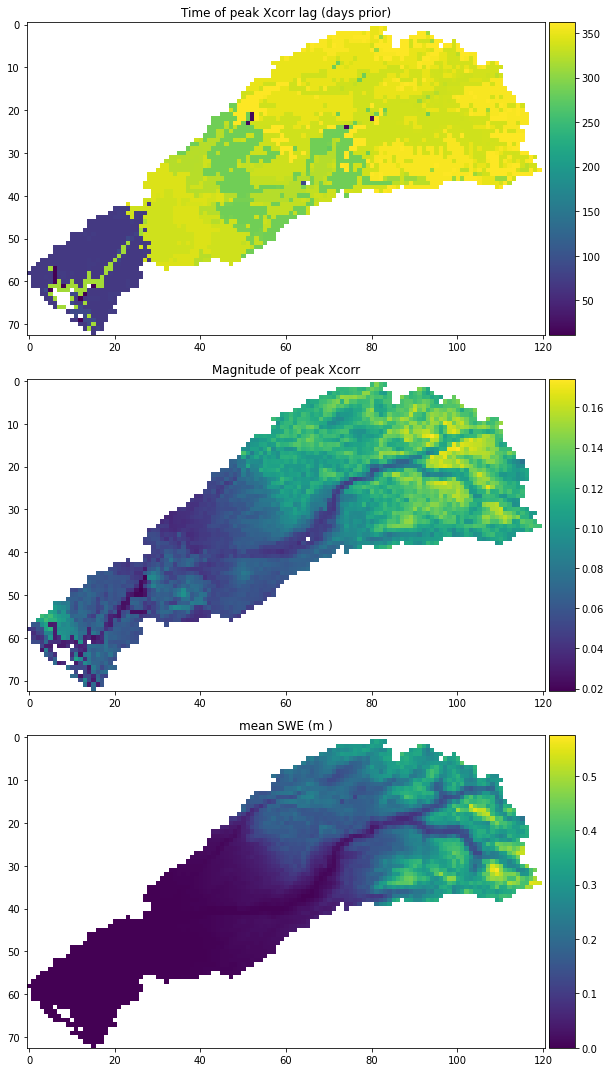

5
************************************************************
ORO FEATHER R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=ORO&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


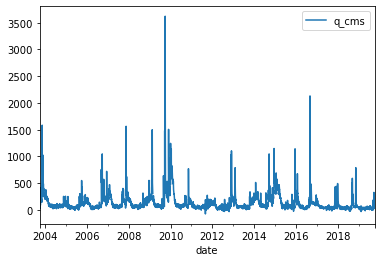

100%|██████████| 6210/6210 [10:59<00:00,  9.41it/s]


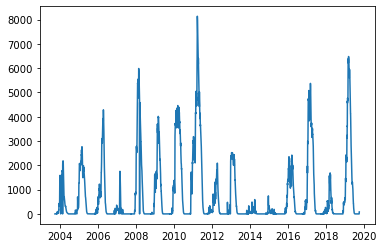

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/ORO_swe.tif
wrote ../rasters/ORO_lag.tif
wrote ../rasters/ORO_cormax.tif


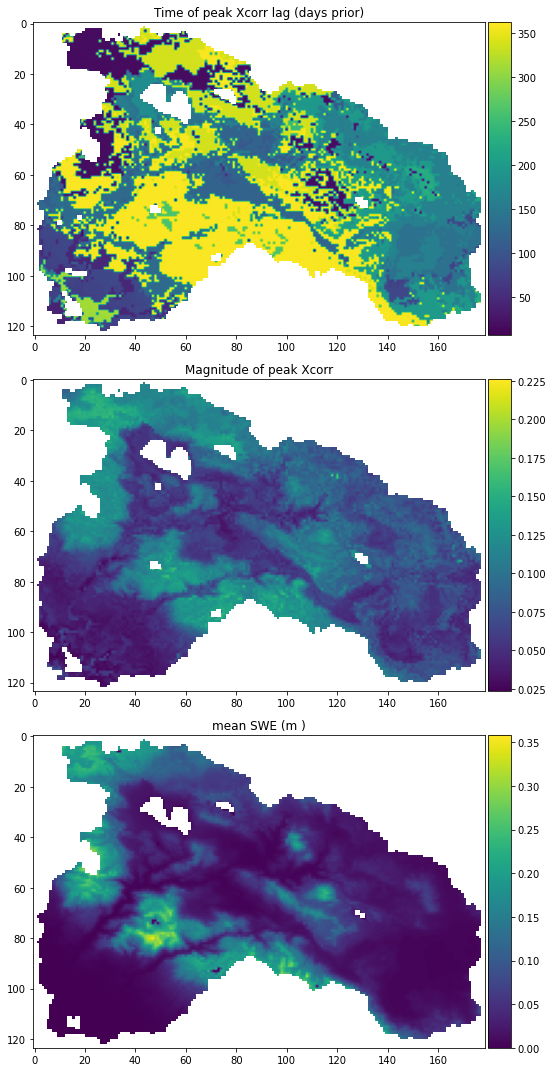

6
************************************************************
FOL AMERICAN R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=FOL&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


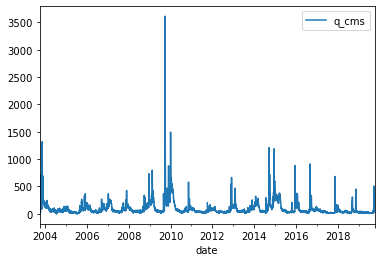

100%|██████████| 6210/6210 [09:09<00:00, 11.31it/s]


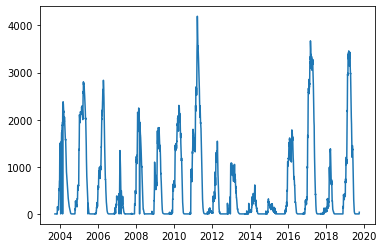

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/FOL_swe.tif
wrote ../rasters/FOL_lag.tif
wrote ../rasters/FOL_cormax.tif


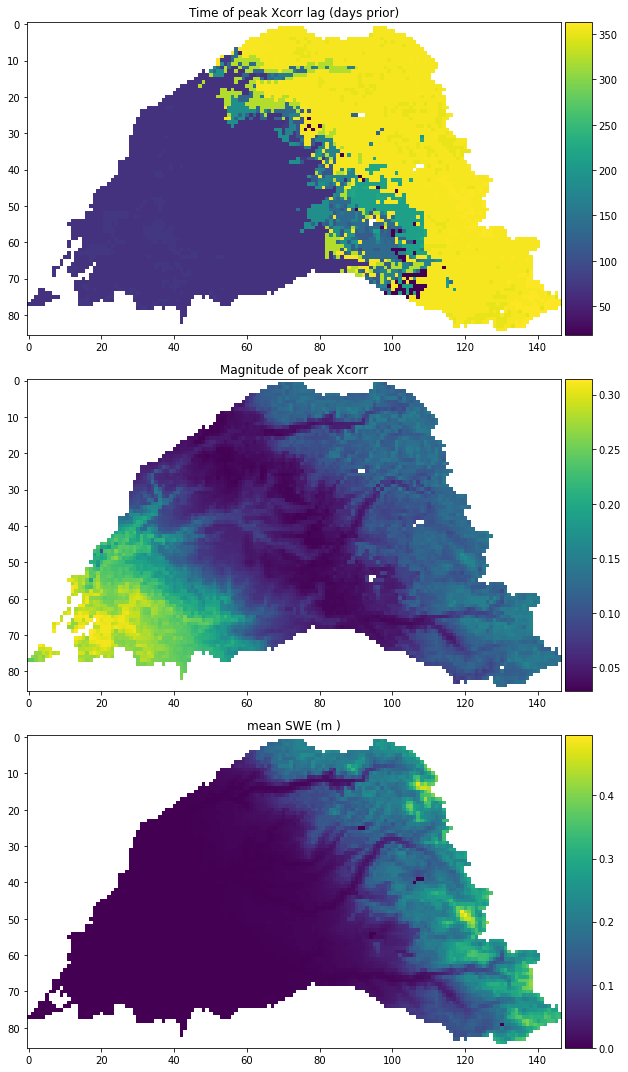

7
************************************************************
TRM KAWEAH R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=TRM&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


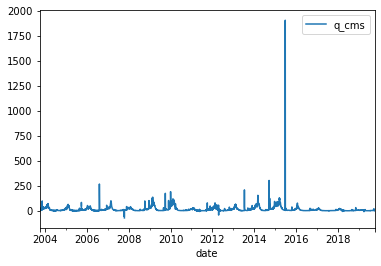

100%|██████████| 6210/6210 [15:11<00:00,  6.81it/s]


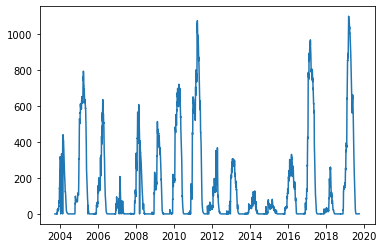

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/TRM_swe.tif
wrote ../rasters/TRM_lag.tif
wrote ../rasters/TRM_cormax.tif


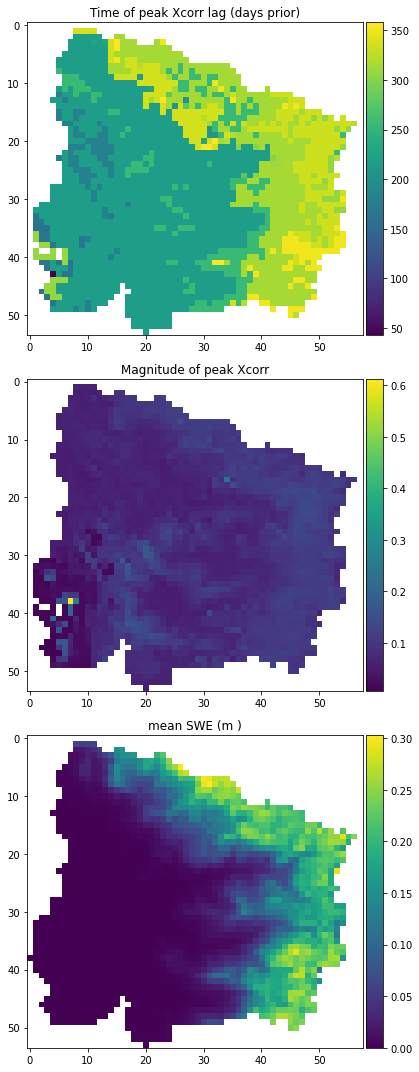

8
************************************************************
SCC TULE R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=SCC&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


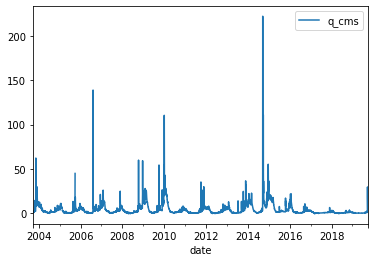

100%|██████████| 6210/6210 [05:46<00:00, 17.94it/s]


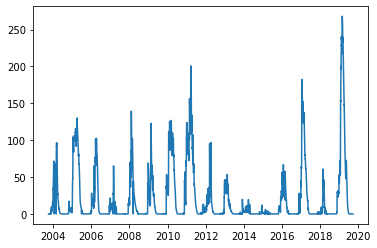

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/SCC_swe.tif
wrote ../rasters/SCC_lag.tif
wrote ../rasters/SCC_cormax.tif


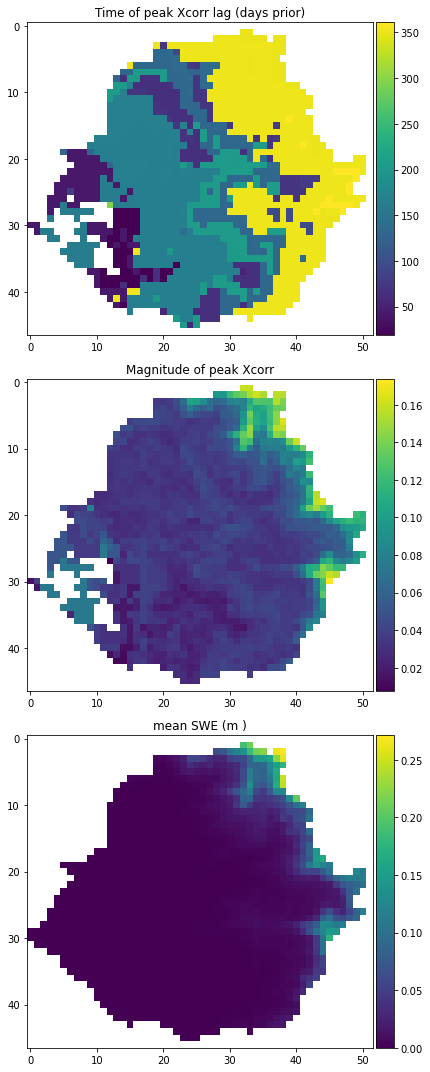

9
************************************************************
CFW BEAR R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=CFW&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01
no data for CFW
10
************************************************************
PNF KINGS R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=PNF&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


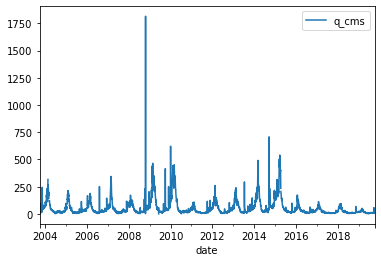

100%|██████████| 6210/6210 [09:39<00:00, 10.71it/s]


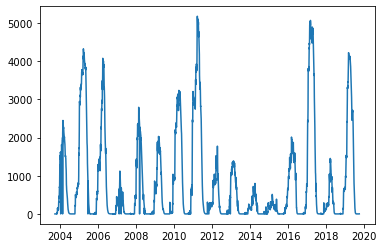

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/PNF_swe.tif
wrote ../rasters/PNF_lag.tif
wrote ../rasters/PNF_cormax.tif


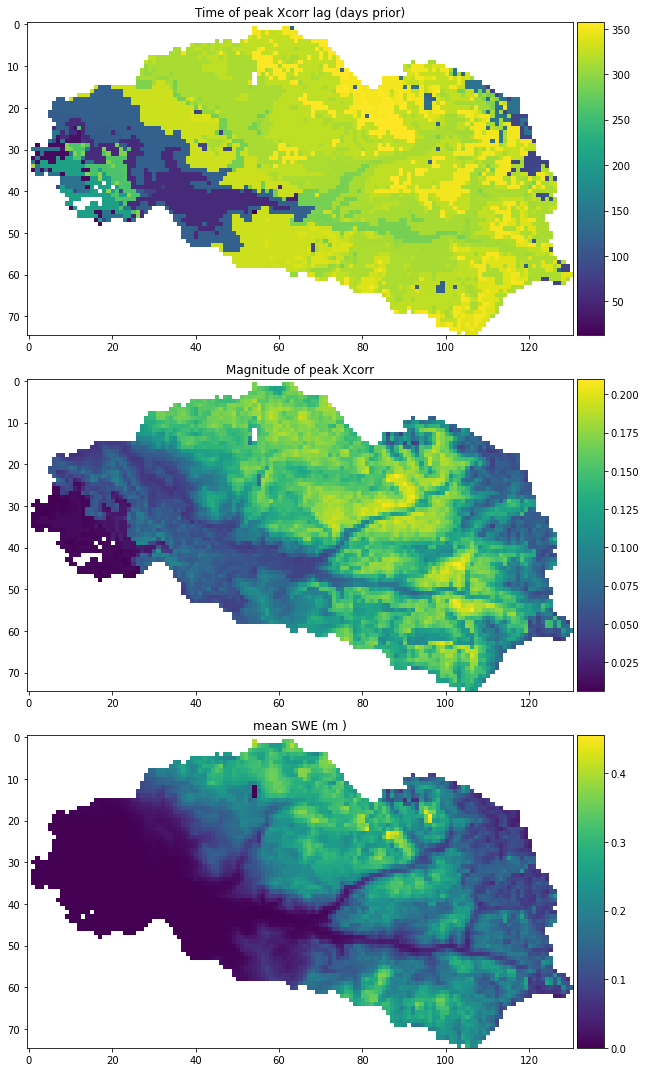

11
************************************************************
MCR MERCED R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=MCR&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01
no data for MCR
12
************************************************************
NHG CALAVERAS R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=NHG&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


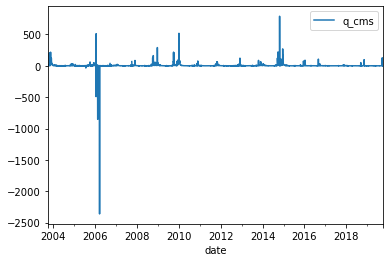

100%|██████████| 6210/6210 [17:04<00:00,  6.06it/s]  


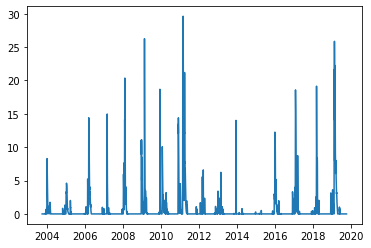

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/NHG_swe.tif
wrote ../rasters/NHG_lag.tif
wrote ../rasters/NHG_cormax.tif


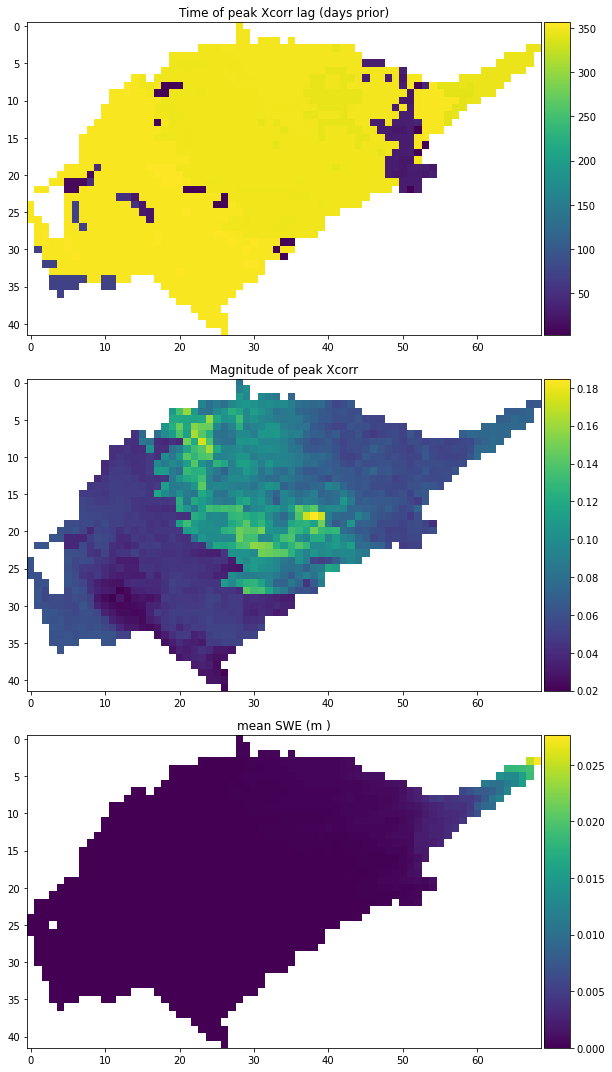

13
************************************************************
SHA SACRAMENTO R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=SHA&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


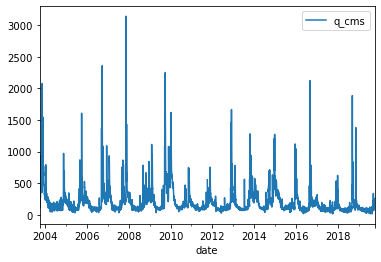

100%|██████████| 6210/6210 [17:03<00:00,  6.07it/s]  


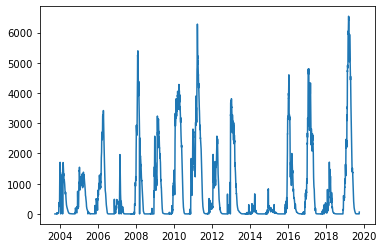

Running Xcorr...


<ipython-input-22-2e3f108da0e8>:90: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


wrote ../rasters/SHA_swe.tif
wrote ../rasters/SHA_lag.tif
wrote ../rasters/SHA_cormax.tif


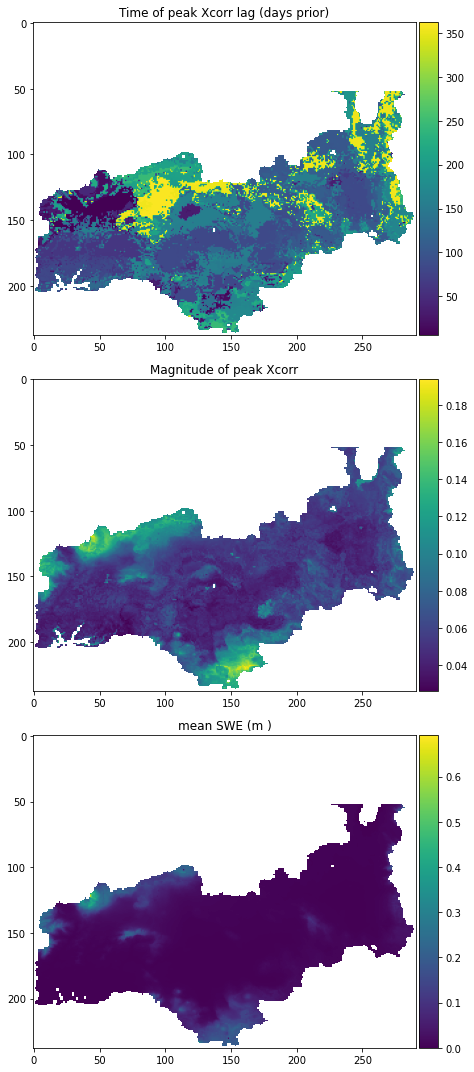

In [22]:
for idx, x in enumerate(gdf[1:].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print(stn_id, row['catch_name'])

    # Get the daily reservoir inflow
    outfn = os.path.join('../data/{}_res.csv'.format(stn_id))
    if not os.path.exists(outfn):
        try:
            outflow = get_res_inflow(stn_id, startdate, enddate)
            outflow.plot()
            outflow.to_csv("../data/{}_res.csv")
            plt.show()
        except:
            print("no data for {}".format(stn_id))
            continue
    else:
        outflow = rs.col_to_dt(pd.read_csv(outfn))
        outflow.plot()
        plt.show()
        
        
    # Get the SWE
    catch_shp = "../shape/{}.shp".format(stn_id)
    swe = get_snodas_swe(catch_shp, startdate, enddate)
    swestack = np.dstack(list(swe.values()))
    # Calc dSWE in time dim
    dswe = np.diff(swestack, axis = 2)
    plt.plot(dt_idx, [np.nansum(x) for x in swe.values()])
    plt.show()
    
    # Format for pxlwise xcorr 
    print("Running Xcorr...")
    
    rows, cols, time = swestack.shape
    px_ts = []
    rclist = []
    
    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = dswe[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(ts_arr)
                rclist.append([row,col])

    pxdf = pd.DataFrame(px_ts).T
    
    # Merge the dfs
    pxdf.index = dt_idx[1:]
    mdf = pd.merge(outflow, pxdf, left_index = True, right_index = True)

    # Compute the cross corr 
    target = 'q_cms'
    df_new = df_shifted(mdf, target, lag=-1)
    lagged_correlation = pd.DataFrame.from_dict(
    {x: [df_new[target].corr(df_new[x].shift(-t)) for t in range(365)] for x in df_new.columns})

    # Drop the target 
    lagged_correlation.drop(['q_cms'], axis =1 , inplace = True)
    # Find the indices of max xcorr
    lagdf = pd.DataFrame(lagged_correlation.abs().idxmax(axis=0)).T # indices
    maxcordf = pd.DataFrame(lagged_correlation.abs().max(axis=0)).T # values

    # Build the out image
    lagim = np.zeros_like(np.mean(swestack, axis = 2))

    # Populate the per-pixel lags 
    for rc, dfcolidx in zip(rclist,lagdf.columns):

        rowidx, colidx = rc
        val = lagdf[dfcolidx].values[0]
        lagim[rowidx,colidx] = val
        
    # Build the out image
    maxcorim = np.zeros_like(np.mean(swestack, axis = 2))

    # Populate the per-pixel max corrs 
    for rc, dfcolidx in zip(rclist,maxcordf.columns):

        rowidx, colidx = rc
        val = maxcordf[dfcolidx].values[0]
        maxcorim[rowidx,colidx] = val
    
    # Compute mean swe and write
    meanswe = np.nanmean(swestack, axis = 2)
    rs.write_raster(meanswe, gp.read_file(catch_shp), '../rasters/{}_swe.tif'.format(stn_id) )
    
    # Mask zeros 
    lagim2 = np.where(lagim!=0,lagim,np.nan)
    maxcorim2 = np.where(maxcorim!=0,maxcorim,np.nan)
    
    # Write  im s
    rs.write_raster(lagim2, gp.read_file(catch_shp), '../rasters/{}_lag.tif'.format(stn_id) )
    rs.write_raster(maxcorim2, gp.read_file(catch_shp), '../rasters/{}_cormax.tif'.format(stn_id) )

    # Plot
    make_plots(lagim2, maxcorim2, meanswe)
    

In [ ]:
# Clip the rasters to the watershed boundaries 

for idx, x in enumerate(gdf[:].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print(stn_id, row['catch_name'])
        
    # Clip rasters to shp 
    catch_shp = "../shape/{}.shp".format(stn_id)
    
    cmd = '''gdalwarp -cutline {} -crop_to_cutline -dstalpha ../rasters/{}_lag.tif ../rasters/{}_lag_cl.tif'''.format(catch_shp, stn_id, stn_id)
    print(cmd)
    os.system(cmd) 


# Run the following to merge rasters:
```gdal_merge.py -n 0 -o snl.tif *cl.tif```
